In [2]:
from typing import Tuple
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import Dataset, DataLoader


import torch
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib as plt
import zipfile
import requests
import io
import re
from sklearn.metrics import classification_report


import os

In [3]:
flicker_dir = Path("../data/flicker")
augmented_dir = Path("../data/augmented")
augmented_dir_no = Path("../data/augmented_no")
augmented_dir_2 = Path("../data/augmented_2")

flicker_dir.mkdir(parents=True, exist_ok=True)
augmented_dir.mkdir(parents=True, exist_ok=True)
data_dir = Path("../data/final_dataset")

In [4]:
# '''Get dataset from flicker'''
# # url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_subset2.zip"
# url_augmented = "https://www.lirmm.fr/~poncelet/Ressources/flickr_long_subset.zip"
# print("Requesting...\n")
# response = requests.get(url_augmented)
# if response.status_code == 200:
#     print("Téléchargement réussi. Extraction...")
#     with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
#         # Extraire sans ajouter de sous-dossier supplémentaire
#         for member in zip_ref.namelist():
#             # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
#             member_path = member
#             if member.startswith("flickr_subset2/"):
#                 member_path = member[len("flickr_subset2/"):]
#             target_path = flicker_dir / member_path

#             # Si c'est un répertoire, on le crée
#             if member.endswith("/"):
#                 target_path.mkdir(exist_ok=True, parents=True)
#             else:
#                 os.makedirs(os.path.dirname(target_path), exist_ok=True)
#                 with zip_ref.open(member) as source, open(target_path, "wb") as target:
#                     target.write(source.read())
#     print(f"Données extraites dans : {flicker_dir}")
# else:
#     print("Échec du téléchargement. Code HTTP :", response.status_code)


In [5]:
!ls ..

'FineTuneBERT (1).ipynb'   data   main.py   notebooks	     uv.lock
 README.md		   figs   models    pyproject.toml


In [6]:
metadata_path = data_dir / "metadata.csv"
df = pd.read_csv(metadata_path)
print(df.columns)
print(df.iloc[0])

Index(['image_path', 'label', 'caption'], dtype='object')
image_path                                     new_ball_683.jpg
label                                                Label.BALL
caption       Two black dogs, their fur fluffed up in agitat...
Name: 0, dtype: object


In [7]:
def get_label(filename: str):
    return filename.split("_")[0]


def get_uuid(filename: str):
    name = Path(filename).stem          
    parts = name.split("_")
    return "_".join(parts[:2])          


def build_augmented_path(img_path: Path, base_dir: Path):
    img_path = Path(img_path)
    filename = img_path.name
    label = get_label(filename)
    uuid = get_uuid(filename)
    print(filename)

    base = re.sub(
        r"^(new|base)_|_(color|spatial)(?=\.)|\.[^.]+$",
        "",
        filename
    )
    print(base)
    print("\n")

    print(base_dir / uuid / base / filename)
    return base_dir / uuid / base / filename

get_label(df["image_path"].iloc[1])
get_uuid(df["image_path"].iloc[1])

print(build_augmented_path(df["image_path"].iloc[1], data_dir))

new_ball_683_spatial.jpg
ball_683


../data/final_dataset/new_ball/ball_683/new_ball_683_spatial.jpg
../data/final_dataset/new_ball/ball_683/new_ball_683_spatial.jpg


### DATASET LOADING

In [163]:
from torchvision import transforms

transform = transforms.Compose(
    [transforms.Resize((300, 500)),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class ImageCLIPDataset(Dataset):
    def __init__(self, imgs, labels, captions,  base_dir: Path, transform):
        
        self.img_paths = [Path(build_augmented_path(img, base_dir)) for img in imgs]
        self.labels = list(labels)
        self.captions = list(captions)
        self.transform = transform
        self.classes = sorted(set(self.labels))                  
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}  


    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")

        label_str = self.labels[idx]
        label = self.class_to_idx[label_str]
        caption = self.captions[idx] if self.captions is not None else "-"

        if self.transform:
            img = self.transform(img)

        return idx, img, label, caption
    
    def __len__(self) -> int:
        return len(self.img_paths)
    
    def _get_img_path_from_idx(self, idx: int) -> Path:
        return self.img_paths[idx]

    def _get_caption_from_idx(self, idx: int) -> Path:
        return self.captions[idx]
    
    def _get_label_from_idx(self, idx: int) -> str :
        return self.labels[idx]
    
    def _get_img_size(self, idx: int) -> Tuple[int, int]:
        print(self.img_paths[idx])

        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    img = t(img)
        return img.height, img.width

    
    
    

        


In [164]:
X =  df["image_path"]
print(X)

0                new_ball_683.jpg
1        new_ball_683_spatial.jpg
2          new_ball_683_color.jpg
3                new_ball_196.jpg
4        new_ball_196_spatial.jpg
                  ...            
4195    base_ball_031_spatial.jpg
4196      base_ball_031_color.jpg
4197            base_ball_137.jpg
4198    base_ball_137_spatial.jpg
4199      base_ball_137_color.jpg
Name: image_path, Length: 4200, dtype: object


In [165]:

df_train, df_temp = train_test_split(df, test_size=0.3, random_state=11)
df_test, df_val = train_test_split(df_temp, test_size=0.5, random_state=11)

print(len(df_train), len(df_test), len(df_val))
print(df_train["label"].value_counts(normalize=True) * 100)
print(df_val["label"].value_counts(normalize=True) * 100)
print(df_test["label"].value_counts(normalize=True) * 100)


2940 630 630
label
Label.BALL     25.782313
Label.WATER    24.897959
Label.DOG      24.761905
Label.BIKE     24.557823
Name: proportion, dtype: float64
label
Label.WATER    26.666667
Label.DOG      25.079365
Label.BALL     24.285714
Label.BIKE     23.968254
Name: proportion, dtype: float64
label
Label.BIKE     28.095238
Label.DOG      26.031746
Label.WATER    23.809524
Label.BALL     22.063492
Name: proportion, dtype: float64


In [166]:
X_train, y_train, train_caption = df_train["image_path"], df_train["label"], df_train["caption"]
X_val, y_val, val_caption = df_val["image_path"], df_val["label"], df_val["caption"]
X_test, y_test, test_caption   = df_test["image_path"], df_test["label"], df_test["caption"]


In [167]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
train_caption = train_caption.reset_index(drop=True)
test_caption = test_caption.reset_index(drop=True)
val_caption = val_caption.reset_index(drop=True)

In [168]:
train_dataset_resnet = ImageCLIPDataset(X_train, y_train, train_caption, data_dir, transform_resnet)
val_dataset_resnet   = ImageCLIPDataset(X_val, y_val, val_caption, data_dir, transform_resnet)
test_dataset_resnet  = ImageCLIPDataset(X_test, y_test, test_caption,  data_dir, transform_resnet)

train_dataset_custom = ImageCLIPDataset(X_train, y_train, train_caption, data_dir, transform)
val_dataset_custom   = ImageCLIPDataset(X_val, y_val, val_caption, data_dir, transform)
test_dataset_custom  = ImageCLIPDataset(X_test, y_test, test_caption, data_dir, transform)



base_ball_070_color.jpg
ball_070


../data/final_dataset/base_ball/ball_070/base_ball_070_color.jpg
new_bike_097_spatial.jpg
bike_097


../data/final_dataset/new_bike/bike_097/new_bike_097_spatial.jpg
base_bike_059_color.jpg
bike_059


../data/final_dataset/base_bike/bike_059/base_bike_059_color.jpg
base_bike_025.jpg
bike_025


../data/final_dataset/base_bike/bike_025/base_bike_025.jpg
new_bike_191.jpg
bike_191


../data/final_dataset/new_bike/bike_191/new_bike_191.jpg
new_dog_662_color.jpg
dog_662


../data/final_dataset/new_dog/dog_662/new_dog_662_color.jpg
new_bike_158_color.jpg
bike_158


../data/final_dataset/new_bike/bike_158/new_bike_158_color.jpg
new_ball_459_color.jpg
ball_459


../data/final_dataset/new_ball/ball_459/new_ball_459_color.jpg
new_dog_1071_color.jpg
dog_1071


../data/final_dataset/new_dog/dog_1071/new_dog_1071_color.jpg
new_ball_107.jpg
ball_107


../data/final_dataset/new_ball/ball_107/new_ball_107.jpg
base_ball_018_spatial.jpg
ball_018


../data/final_dataset/

../data/final_dataset/base_bike/bike_025/base_bike_025.jpg
(224, 224)
../data/final_dataset/new_dog/dog_1013/new_dog_1013_color.jpg
(224, 224)
base_bike_025.jpg
bike_025


../data/final_dataset/base_bike/bike_025/base_bike_025.jpg


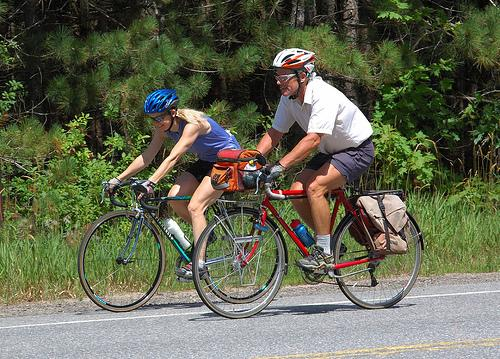

(3, tensor([[[-1.7069, -1.9980, -1.9124,  ..., -1.4329, -1.3302, -1.7583],
         [-1.5699, -1.6727, -1.6898,  ..., -0.8678, -0.9363, -1.6727],
         [-1.0390, -1.0733, -1.1418,  ...,  0.0398, -1.0048, -1.5699],
         ...,
         [ 0.8618,  1.0502,  0.9646,  ...,  0.9988,  0.9646,  1.0844],
         [ 0.7762,  0.9303,  0.9817,  ...,  1.0331,  0.9817,  0.8104],
         [ 0.7933,  0.9817,  0.9474,  ...,  1.1529,  1.0159,  0.8276]],

        [[-1.3880, -1.7381, -1.7031,  ..., -1.3880, -1.2829, -1.7206],
         [-1.2304, -1.3704, -1.4580,  ..., -0.7402, -0.8277, -1.5805],
         [-0.6527, -0.7577, -0.9328,  ...,  0.2752, -0.8277, -1.3880],
         ...,
         [ 1.0630,  1.2556,  1.1681,  ...,  1.2031,  1.1856,  1.3081],
         [ 0.9755,  1.1331,  1.1856,  ...,  1.2381,  1.2031,  1.0280],
         [ 0.9930,  1.1856,  1.1506,  ...,  1.3431,  1.2381,  1.0455]],

        [[-1.4559, -1.7522, -1.6824,  ..., -1.2990, -1.2467, -1.6476],
         [-1.3513, -1.4733, -1.5081,  ...

In [169]:
print(train_dataset_resnet._get_img_size(3))
print(train_dataset_resnet._get_img_size(13))
img = train_dataset_resnet._get_img_path_from_idx(3)
lg = Image.open(build_augmented_path(img, data_dir))
display(lg)
print(train_dataset_resnet.__getitem__(3))

In [170]:
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)
val_loader_resnet   = DataLoader(val_dataset_resnet, batch_size=32, shuffle=False)
test_loader_resnet  = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)

train_loader_custom = DataLoader(train_dataset_custom, batch_size=32, shuffle=True)
val_loader_custom   = DataLoader(val_dataset_custom, batch_size=32, shuffle=False)
test_loader_custom  = DataLoader(test_dataset_custom, batch_size=32, shuffle=False)



### MODEL IMPLEMENTATION

In [16]:
class CNNBasic(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2)
        )

        self.flattened_size = self._get_flattened_size()

        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 300, 500)
            x = self.features(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [193]:
import torch
import torch.nn as nn

class CNNBasicV2(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        def block(in_ch, out_ch, pool=True):
            layers = [
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            block(3, 32, pool=True),    # 300x500 -> 150x250
            block(32, 64, pool=True),   # -> 75x125
            block(64, 128, pool=True),  # -> 37x62
            block(128, 256, pool=False) # pas de pool ici (garde un peu de spatial)
        )

        # Dropout sur feature maps (souvent meilleur que dropout sur FC pour CNN)
        self.dropout = nn.Dropout2d(p=0.2)

        # Global Average Pooling => [B, 256, 1, 1]
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier léger (beaucoup moins de paramètres que ton Linear géant)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = self.gap(x).flatten(1)  # [B, 256]
        return self.classifier(x)


### RESNET IMPLEMENTATION

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
class ResNet18EarlyExit(nn.Module):
    def __init__(self, num_classes=4, threshold=0.9):
        super().__init__()
        self.threshold = threshold

        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.stem = nn.Sequential(
            base.conv1, base.bn1, base.relu, base.maxpool
        )
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        
        self.exit1 = self._make_exit(64, num_classes)
        self.exit2 = self._make_exit(128, num_classes)
        self.exit3 = self._make_exit(256, num_classes)
        self.exit4 = nn.Linear(base.fc.in_features, num_classes)

    def _make_exit(self, channels, num_classes):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(channels, num_classes)
        )
    def extract_features(self, x):
        features = {}

        x = self.stem(x)
        x = self.layer1(x)
        f1 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit1"] = f1

        x = self.layer2(x)
        f2 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit2"] = f2

        x = self.layer3(x)
        f3 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit3"] = f3

        x = self.layer4(x)
        f4 = torch.flatten(nn.AdaptiveAvgPool2d((1,1))(x), 1)
        features["exit4"] = f4

        return features
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        out1 = self.exit1(x)
        if self._confident(out1):
            return out1
        
        x = self.layer2(x)
        out2 = self.exit2(x)
        if self._confident(out2):
            return out2
        
        x = self.layer3(x)
        out3 = self.exit3(x)
        if self._confident(out3):
            return out3
        
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = torch.flatten(x, 1)
        out4 = self.exit4(x)
        return out4, 4

    def _confident(self, logits):
        probs = logits.softmax(dim=1)
        max_conf = probs.max(dim=1).values
        return (max_conf > self.threshold).any()


### GRAD CAM

In [177]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    """
    Grad-CAM for a given model + target layer.
    Works for CNNs that output logits [B, num_classes].
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        self._fwd_handle = target_layer.register_forward_hook(self._forward_hook)
        self._bwd_handle = target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        # grad_out is a tuple; grad_out[0] shape == activations shape
        self.gradients = grad_out[0].detach()

    def remove(self):
        self._fwd_handle.remove()
        self._bwd_handle.remove()

    def __call__(self, x, class_idx=None):
        """
        x: Tensor [1, C, H, W]
        class_idx: int or None -> if None, uses predicted class
        returns: cam (H', W') in [0,1], pred_class, probs
        """
        self.model.zero_grad(set_to_none=True)
        logits = self.model(x)  # [1, num_classes]
        probs = torch.softmax(logits, dim=1)

        pred_class = int(probs.argmax(dim=1).item())
        target_class = pred_class if class_idx is None else int(class_idx)

        score = logits[0, target_class]
        score.backward(retain_graph=False)

        # activations: [1, K, H', W'], gradients: [1, K, H', W']
        grads = self.gradients[0]      # [K, H', W']
        acts = self.activations[0]     # [K, H', W']

        # Global-average-pool gradients over spatial dims -> weights [K]
        weights = grads.mean(dim=(1, 2))  # [K]

        # Weighted sum of activations
        cam = (weights[:, None, None] * acts).sum(dim=0)  # [H', W']
        cam = F.relu(cam)

        # Normalize to [0,1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy(), pred_class, probs.detach().cpu().numpy()[0]

def get_last_conv_layer(model):
    last_conv = model.features[8]  # dernière Conv2d
    return last_conv


### TRAINING AND VALIDATION METHODS

In [198]:
def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)

def make_class_names(dataset):
    # dataset.class_to_idx: {label_str: idx}
    idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
    return [idx_to_class[i] for i in range(len(idx_to_class))]


def to_device(x, device):
    return x.to(device, non_blocking=True)


def train_one_epoch(model, loader, optimizer, criterion, device, epoch, epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(
        enumerate(loader, 0),
        total=len(loader),
        desc=f"Epoch {epoch+1}/{epochs} [TRAIN]"
    )

    for i, data in loop:
        idx, inputs, labels, caption = data
        inputs = to_device(inputs, device)
        labels = to_device(labels, device)


        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (i + 1))

    avg_loss = running_loss / len(loader)
    return avg_loss


@torch.no_grad()
def evaluate(
    model,
    loader,
    criterion,
    device,
    epoch,
    epochs,
    num_classes,
    dataset=None,                 
    class_names=None,             
    caption_fn=None,              
    n_mistakes_to_print=5
):
    model.eval()
    running_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    mistakes_printed = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [EVAL]")

    for batch in loop:
        idxs, inputs, labels, captions = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

      
        logits = model(inputs)
        loss = criterion(logits, labels)
        running_loss += loss.item()

        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels)
        all_preds.append(preds)
        all_probs.append(probs)


        can_print_mistakes = (dataset is not None) and (class_names is not None)
        if can_print_mistakes and mistakes_printed < n_mistakes_to_print:
            mism_mask = (preds != labels).detach().cpu()
            if mism_mask.any():
                mism_positions = torch.where(mism_mask)[0].tolist()
                for pos in mism_positions:
                    if mistakes_printed >= n_mistakes_to_print:
                        break

                    sample_idx = int(idxs[pos].item())  # idx du dataset
                    true_i = int(labels[pos].item())
                    pred_i = int(preds[pos].item())

                    true_name = class_names[true_i]
                    pred_name = class_names[pred_i]

                    img_path = dataset._get_img_path_from_idx(sample_idx)
                    display(Image.open(img_path).convert('RGB'))
                    # si tu as une caption, via callback; sinon on affiche "-"
                    caption = dataset._get_caption_from_idx(sample_idx)

                    print("\n--- Mauvaise prédiction ---")
                    print(f"dataset_idx : {sample_idx}")
                    print(f"image      : {img_path}")
                    print(f"vrai label : {true_name} ({true_i})")
                    print(f"prédit     : {pred_name} ({pred_i})")
                    print(f"caption    : {caption}")

                    mistakes_printed += 1

    avg_loss = running_loss / len(loader)

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)

    accuracy = (all_preds == all_labels).float().mean().item()

    return (
        avg_loss,
        all_labels.cpu().numpy(),
        all_preds.cpu().numpy(),
        all_probs.cpu().numpy(),
        accuracy
    )

@torch.no_grad()
def evaluate_while_training(
    model,
    loader,
    criterion,
    device,
    epoch,
    epochs,
):
    model.eval()
    running_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    mistakes_printed = 0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs} [EVAL]")

    for batch in loop:
        idxs, inputs, labels, captions = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

      
        logits = model(inputs)
        loss = criterion(logits, labels)
        running_loss += loss.item()

        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels)
        all_preds.append(preds)
        all_probs.append(probs)

    avg_loss = running_loss / len(loader)

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)

    accuracy = (all_preds == all_labels).float().mean().item()

    return (
        avg_loss,
        all_labels.cpu().numpy(),
        all_preds.cpu().numpy(),
        all_probs.cpu().numpy(),
        accuracy
    )


In [179]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_multiclass_roc(y_true, y_prob, num_classes, class_names=None, title="ROC (One-vs-Rest)"):
    """
    y_true: [N] int labels
    y_prob: [N, C] probabilities
    """
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # [N, C]

    plt.figure(figsize=(8, 6))
    for c in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], y_prob[:, c])
        roc_auc = auc(fpr, tpr)
        name = class_names[c] if class_names is not None else f"Class {c}"
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

    # Diagonal
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def fit(
    model,
    train_loader,
    test_loader,
    num_classes=4,
    epochs=50,
    lr=1e-3,
    momentum=0.9,
    patience=5,
    models_dir=Path("../models"),
    best_name="best_model.pth",
    criterion=None,
    class_names=None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if criterion is None:
        criterion = nn.CrossEntropyLoss()


    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    ensure_dir(models_dir)
    best_model_path = models_dir / best_name

    best_test_loss = float("inf")
    patience_counter = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion, device, epoch, epochs
        )
        train_losses.append(train_loss)
        print(f"\nEpoch {epoch+1} - Average TRAIN loss: {train_loss:.4f}")

        test_loss, y_true, y_pred, y_prob, acc = evaluate_while_training(
            model, test_loader, criterion, device, epoch, epochs
        )
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1} - Average TEST loss: {test_loss:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3))

        # Early stopping + save best
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Nouveau meilleur modèle sauvegardé (test loss: {best_test_loss:.4f})")
        else:
            patience_counter += 1
            print(f"Pas d'amélioration ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print(f"\nEarly stopping déclenché après {epoch+1} époques")
                print(f"Meilleur test loss: {best_test_loss:.4f}")
                break

    # Load best model + final evaluation for plots
    print(f"\nChargement du meilleur modèle (test loss: {best_test_loss:.4f})")
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    final_test_loss, y_true, y_pred, y_prob = evaluate(
        model, test_loader, criterion, device, epoch=0, epochs=1, num_classes=num_classes
    )
    print(f"Best model - TEST loss: {final_test_loss:.4f}")

    # Plots
    plot_losses(train_losses, test_losses)
    plot_confusion_matrix(y_true, y_pred, class_names=class_names, title="Confusion Matrix (Best Model)")
    plot_multiclass_roc(y_true, y_prob, num_classes=num_classes, class_names=class_names, title="ROC (Best Model, OvR)")
    return model, {"train_losses": train_losses, "test_losses": test_losses, "best_test_loss": best_test_loss}


In [181]:
def denorm_05(t):
    # t: Tensor [3,H,W] in [-1,1]
    return (t * 0.5 + 0.5).clamp(0, 1)

def show_cam_overlay(img_tensor, cam, title="Grad-CAM"):
    """
    img_tensor: [3,H,W] (normalized), cam: [H',W'] from GradCAM
    """
    img = denorm_05(img_tensor).permute(1,2,0).cpu().numpy()  # [H,W,3]

    # Resize cam to image size
    cam_t = torch.tensor(cam)[None, None, ...]  # [1,1,H',W']
    cam_resized = F.interpolate(cam_t, size=img.shape[:2], mode="bilinear", align_corners=False)
    cam_resized = cam_resized[0,0].cpu().numpy()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.imshow(cam_resized, alpha=0.45)  # overlay
    plt.axis("off")
    plt.title(title)

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F

def show_5_mistakes_with_gradcam(
    model,
    loader,
    device,
    class_names,
    target_layer,          # ex: model.features[8]
    dataset=None,
    n=5
):
    model.eval()
    gc = GradCAM(model, target_layer)
    shown = 0

    for idxs, inputs, labels, captions in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        mism = (preds != labels).detach().cpu()
        if mism.any():
            for pos in torch.where(mism)[0].tolist():
                if shown >= n:
                    gc.remove()
                    return

                sample_idx = int(idxs[pos].item())
                true_i = int(labels[pos].item())
                pred_i = int(preds[pos].item())

                true_name = class_names[true_i]
                pred_name = class_names[pred_i]
                caption = captions[pos]

                img_path = dataset._get_img_path_from_idx(sample_idx) if dataset is not None else "N/A"

                print("\n--- Mauvaise prédiction ---")
                print(f"dataset_idx : {sample_idx}")
                print(f"image      : {img_path}")
                print(f"vrai label : {true_name} ({true_i})")
                print(f"prédit     : {pred_name} ({pred_i})")
                print(f"caption    : {caption}")

                x1 = inputs[pos:pos+1].detach()
                x1.requires_grad_(True)

                cam_map, _, _ = gc(x1, class_idx=pred_i)

                show_cam_overlay(
                    inputs[pos].detach().cpu(),
                    cam_map,
                    title=f"Grad-CAM (true={true_name} pred={pred_name})"
                )

                shown += 1

    gc.remove()


### TRAINING V2


In [202]:
model = CNNBasicV2(4)  
trained_model, history = fit(
    model=model,
    train_loader=train_loader_custom,
    test_loader=test_loader_custom,
    num_classes=4,
    epochs=50,
    lr=1e-3,
    momentum=0.9,
    patience=5,
    models_dir=Path("../models"),
    best_name="best_model_v2.pth",
    criterion=nn.CrossEntropyLoss(),
    class_names=class_names,
)

Epoch 1/50 [TRAIN]: 100%|██████████| 92/92 [00:36<00:00,  2.51it/s, loss=1.37]



Epoch 1 - Average TRAIN loss: 1.3659


Epoch 1/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


Epoch 1 - Average TEST loss: 1.3190

Classification Report:
              precision    recall  f1-score   support

           0      0.377     0.604     0.464       139
           1      0.464     0.508     0.485       177
           2      0.540     0.165     0.252       164
           3      0.393     0.427     0.409       150

    accuracy                          0.421       630
   macro avg      0.443     0.426     0.403       630
weighted avg      0.448     0.421     0.402       630

Nouveau meilleur modèle sauvegardé (test loss: 1.3190)


Epoch 2/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.63it/s, loss=1.31]



Epoch 2 - Average TRAIN loss: 1.3142


Epoch 2/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


Epoch 2 - Average TEST loss: 1.2628

Classification Report:
              precision    recall  f1-score   support

           0      0.449     0.475     0.462       139
           1      0.445     0.525     0.482       177
           2      0.524     0.396     0.451       164
           3      0.433     0.433     0.433       150

    accuracy                          0.459       630
   macro avg      0.463     0.457     0.457       630
weighted avg      0.464     0.459     0.458       630

Nouveau meilleur modèle sauvegardé (test loss: 1.2628)


Epoch 3/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s, loss=1.29]



Epoch 3 - Average TRAIN loss: 1.2929


Epoch 3/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Epoch 3 - Average TEST loss: 1.2347

Classification Report:
              precision    recall  f1-score   support

           0      0.405     0.446     0.425       139
           1      0.441     0.548     0.489       177
           2      0.477     0.378     0.422       164
           3      0.480     0.407     0.440       150

    accuracy                          0.448       630
   macro avg      0.451     0.445     0.444       630
weighted avg      0.452     0.448     0.446       630

Nouveau meilleur modèle sauvegardé (test loss: 1.2347)


Epoch 4/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s, loss=1.27]



Epoch 4 - Average TRAIN loss: 1.2679


Epoch 4/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


Epoch 4 - Average TEST loss: 1.2113

Classification Report:
              precision    recall  f1-score   support

           0      0.403     0.554     0.467       139
           1      0.478     0.565     0.518       177
           2      0.511     0.287     0.367       164
           3      0.471     0.433     0.451       150

    accuracy                          0.459       630
   macro avg      0.466     0.460     0.451       630
weighted avg      0.469     0.459     0.452       630

Nouveau meilleur modèle sauvegardé (test loss: 1.2113)


Epoch 5/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s, loss=1.25]



Epoch 5 - Average TRAIN loss: 1.2453


Epoch 5/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


Epoch 5 - Average TEST loss: 1.2030

Classification Report:
              precision    recall  f1-score   support

           0      0.384     0.547     0.451       139
           1      0.554     0.463     0.505       177
           2      0.523     0.415     0.463       164
           3      0.448     0.460     0.454       150

    accuracy                          0.468       630
   macro avg      0.477     0.471     0.468       630
weighted avg      0.483     0.468     0.470       630

Nouveau meilleur modèle sauvegardé (test loss: 1.2030)


Epoch 6/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.61it/s, loss=1.23]



Epoch 6 - Average TRAIN loss: 1.2348


Epoch 6/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


Epoch 6 - Average TEST loss: 1.1811

Classification Report:
              precision    recall  f1-score   support

           0      0.432     0.460     0.446       139
           1      0.475     0.599     0.530       177
           2      0.486     0.415     0.447       164
           3      0.496     0.393     0.439       150

    accuracy                          0.471       630
   macro avg      0.472     0.467     0.466       630
weighted avg      0.473     0.471     0.468       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1811)


Epoch 7/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.63it/s, loss=1.21]



Epoch 7 - Average TRAIN loss: 1.2108


Epoch 7/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


Epoch 7 - Average TEST loss: 1.1693

Classification Report:
              precision    recall  f1-score   support

           0      0.476     0.424     0.449       139
           1      0.486     0.599     0.537       177
           2      0.497     0.457     0.476       164
           3      0.511     0.467     0.488       150

    accuracy                          0.492       630
   macro avg      0.492     0.487     0.487       630
weighted avg      0.493     0.492     0.490       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1693)


Epoch 8/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s, loss=1.2]



Epoch 8 - Average TRAIN loss: 1.2013


Epoch 8/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


Epoch 8 - Average TEST loss: 1.1582

Classification Report:
              precision    recall  f1-score   support

           0      0.473     0.381     0.422       139
           1      0.514     0.627     0.565       177
           2      0.556     0.396     0.463       164
           3      0.449     0.553     0.496       150

    accuracy                          0.495       630
   macro avg      0.498     0.490     0.486       630
weighted avg      0.500     0.495     0.490       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1582)


Epoch 9/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.63it/s, loss=1.19]



Epoch 9 - Average TRAIN loss: 1.1932


Epoch 9/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


Epoch 9 - Average TEST loss: 1.1442

Classification Report:
              precision    recall  f1-score   support

           0      0.386     0.525     0.445       139
           1      0.554     0.667     0.605       177
           2      0.571     0.341     0.427       164
           3      0.508     0.440     0.471       150

    accuracy                          0.497       630
   macro avg      0.505     0.493     0.487       630
weighted avg      0.510     0.497     0.492       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1442)


Epoch 10/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.67it/s, loss=1.18]



Epoch 10 - Average TRAIN loss: 1.1819


Epoch 10/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]


Epoch 10 - Average TEST loss: 1.1607

Classification Report:
              precision    recall  f1-score   support

           0      0.362     0.547     0.436       139
           1      0.721     0.452     0.556       177
           2      0.584     0.360     0.445       164
           3      0.442     0.613     0.514       150

    accuracy                          0.487       630
   macro avg      0.527     0.493     0.488       630
weighted avg      0.540     0.487     0.490       630

Pas d'amélioration (1/5)


Epoch 11/50 [TRAIN]: 100%|██████████| 92/92 [00:35<00:00,  2.62it/s, loss=1.17]



Epoch 11 - Average TRAIN loss: 1.1709


Epoch 11/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


Epoch 11 - Average TEST loss: 1.1351

Classification Report:
              precision    recall  f1-score   support

           0      0.383     0.496     0.433       139
           1      0.602     0.582     0.592       177
           2      0.568     0.384     0.458       164
           3      0.494     0.553     0.522       150

    accuracy                          0.505       630
   macro avg      0.512     0.504     0.501       630
weighted avg      0.519     0.505     0.505       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1351)


Epoch 12/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.17]



Epoch 12 - Average TRAIN loss: 1.1717


Epoch 12/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Epoch 12 - Average TEST loss: 1.1150

Classification Report:
              precision    recall  f1-score   support

           0      0.569     0.295     0.389       139
           1      0.608     0.667     0.636       177
           2      0.475     0.640     0.545       164
           3      0.552     0.527     0.539       150

    accuracy                          0.544       630
   macro avg      0.551     0.532     0.527       630
weighted avg      0.552     0.544     0.535       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1150)


Epoch 13/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.15]



Epoch 13 - Average TRAIN loss: 1.1543


Epoch 13/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


Epoch 13 - Average TEST loss: 1.1450

Classification Report:
              precision    recall  f1-score   support

           0      0.645     0.288     0.398       139
           1      0.627     0.588     0.606       177
           2      0.474     0.671     0.556       164
           3      0.494     0.560     0.525       150

    accuracy                          0.537       630
   macro avg      0.560     0.527     0.521       630
weighted avg      0.559     0.537     0.528       630

Pas d'amélioration (1/5)


Epoch 14/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.16]



Epoch 14 - Average TRAIN loss: 1.1595


Epoch 14/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


Epoch 14 - Average TEST loss: 1.1277

Classification Report:
              precision    recall  f1-score   support

           0      0.479     0.496     0.488       139
           1      0.659     0.610     0.633       177
           2      0.562     0.329     0.415       164
           3      0.420     0.633     0.505       150

    accuracy                          0.517       630
   macro avg      0.530     0.517     0.510       630
weighted avg      0.537     0.517     0.514       630

Pas d'amélioration (2/5)


Epoch 15/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.15]



Epoch 15 - Average TRAIN loss: 1.1519


Epoch 15/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Epoch 15 - Average TEST loss: 1.1404

Classification Report:
              precision    recall  f1-score   support

           0      0.398     0.504     0.444       139
           1      0.757     0.475     0.583       177
           2      0.573     0.457     0.508       164
           3      0.462     0.653     0.541       150

    accuracy                          0.519       630
   macro avg      0.547     0.522     0.519       630
weighted avg      0.559     0.519     0.523       630

Pas d'amélioration (3/5)


Epoch 16/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.13]



Epoch 16 - Average TRAIN loss: 1.1342


Epoch 16/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Epoch 16 - Average TEST loss: 1.0981

Classification Report:
              precision    recall  f1-score   support

           0      0.504     0.410     0.452       139
           1      0.703     0.576     0.634       177
           2      0.543     0.543     0.543       164
           3      0.481     0.667     0.559       150

    accuracy                          0.552       630
   macro avg      0.558     0.549     0.547       630
weighted avg      0.565     0.552     0.552       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0981)


Epoch 17/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.14]



Epoch 17 - Average TRAIN loss: 1.1437


Epoch 17/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Epoch 17 - Average TEST loss: 1.0921

Classification Report:
              precision    recall  f1-score   support

           0      0.457     0.345     0.393       139
           1      0.587     0.723     0.648       177
           2      0.503     0.445     0.472       164
           3      0.543     0.587     0.564       150

    accuracy                          0.535       630
   macro avg      0.523     0.525     0.520       630
weighted avg      0.526     0.535     0.526       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0921)


Epoch 18/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.13]



Epoch 18 - Average TRAIN loss: 1.1329


Epoch 18/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


Epoch 18 - Average TEST loss: 1.0966

Classification Report:
              precision    recall  f1-score   support

           0      0.460     0.331     0.385       139
           1      0.558     0.734     0.634       177
           2      0.506     0.543     0.524       164
           3      0.628     0.507     0.561       150

    accuracy                          0.541       630
   macro avg      0.538     0.529     0.526       630
weighted avg      0.539     0.541     0.533       630

Pas d'amélioration (1/5)


Epoch 19/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.13]



Epoch 19 - Average TRAIN loss: 1.1289


Epoch 19/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Epoch 19 - Average TEST loss: 1.0910

Classification Report:
              precision    recall  f1-score   support

           0      0.587     0.317     0.411       139
           1      0.685     0.627     0.655       177
           2      0.551     0.494     0.521       164
           3      0.447     0.733     0.556       150

    accuracy                          0.549       630
   macro avg      0.568     0.543     0.536       630
weighted avg      0.572     0.549     0.543       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0910)


Epoch 20/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.12]



Epoch 20 - Average TRAIN loss: 1.1156


Epoch 20/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Epoch 20 - Average TEST loss: 1.0848

Classification Report:
              precision    recall  f1-score   support

           0      0.529     0.266     0.354       139
           1      0.632     0.661     0.646       177
           2      0.479     0.628     0.544       164
           3      0.537     0.573     0.555       150

    accuracy                          0.544       630
   macro avg      0.544     0.532     0.525       630
weighted avg      0.547     0.544     0.533       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0848)


Epoch 21/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.12]



Epoch 21 - Average TRAIN loss: 1.1150


Epoch 21/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Epoch 21 - Average TEST loss: 1.0813

Classification Report:
              precision    recall  f1-score   support

           0      0.453     0.525     0.487       139
           1      0.630     0.684     0.656       177
           2      0.567     0.360     0.440       164
           3      0.538     0.620     0.576       150

    accuracy                          0.549       630
   macro avg      0.547     0.547     0.540       630
weighted avg      0.553     0.549     0.543       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0813)


Epoch 22/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.11]



Epoch 22 - Average TRAIN loss: 1.1146


Epoch 22/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


Epoch 22 - Average TEST loss: 1.0831

Classification Report:
              precision    recall  f1-score   support

           0      0.656     0.288     0.400       139
           1      0.544     0.740     0.627       177
           2      0.562     0.415     0.477       164
           3      0.483     0.667     0.560       150

    accuracy                          0.538       630
   macro avg      0.561     0.527     0.516       630
weighted avg      0.559     0.538     0.522       630

Pas d'amélioration (1/5)


Epoch 23/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.64it/s, loss=1.11]



Epoch 23 - Average TRAIN loss: 1.1134


Epoch 23/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]


Epoch 23 - Average TEST loss: 1.0641

Classification Report:
              precision    recall  f1-score   support

           0      0.600     0.281     0.382       139
           1      0.659     0.667     0.663       177
           2      0.477     0.689     0.564       164
           3      0.591     0.587     0.589       150

    accuracy                          0.568       630
   macro avg      0.582     0.556     0.549       630
weighted avg      0.582     0.568     0.557       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0641)


Epoch 24/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.1]



Epoch 24 - Average TRAIN loss: 1.0972


Epoch 24/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.19it/s]


Epoch 24 - Average TEST loss: 1.0404

Classification Report:
              precision    recall  f1-score   support

           0      0.567     0.273     0.369       139
           1      0.569     0.791     0.662       177
           2      0.532     0.506     0.519       164
           3      0.590     0.633     0.611       150

    accuracy                          0.565       630
   macro avg      0.565     0.551     0.540       630
weighted avg      0.564     0.565     0.548       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0404)


Epoch 25/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.1]



Epoch 25 - Average TRAIN loss: 1.0957


Epoch 25/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


Epoch 25 - Average TEST loss: 1.0277

Classification Report:
              precision    recall  f1-score   support

           0      0.518     0.417     0.462       139
           1      0.621     0.740     0.675       177
           2      0.614     0.494     0.547       164
           3      0.560     0.653     0.603       150

    accuracy                          0.584       630
   macro avg      0.578     0.576     0.572       630
weighted avg      0.582     0.584     0.578       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0277)


Epoch 26/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.66it/s, loss=1.1]



Epoch 26 - Average TRAIN loss: 1.1003


Epoch 26/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


Epoch 26 - Average TEST loss: 1.0408

Classification Report:
              precision    recall  f1-score   support

           0      0.554     0.331     0.414       139
           1      0.665     0.684     0.674       177
           2      0.542     0.555     0.548       164
           3      0.528     0.693     0.599       150

    accuracy                          0.575       630
   macro avg      0.572     0.566     0.559       630
weighted avg      0.576     0.575     0.566       630

Pas d'amélioration (1/5)


Epoch 27/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=1.09]



Epoch 27 - Average TRAIN loss: 1.0907


Epoch 27/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


Epoch 27 - Average TEST loss: 1.1076

Classification Report:
              precision    recall  f1-score   support

           0      0.455     0.331     0.383       139
           1      0.503     0.825     0.625       177
           2      0.600     0.384     0.468       164
           3      0.522     0.467     0.493       150

    accuracy                          0.516       630
   macro avg      0.520     0.502     0.492       630
weighted avg      0.523     0.516     0.500       630

Pas d'amélioration (2/5)


Epoch 28/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.68it/s, loss=1.08]



Epoch 28 - Average TRAIN loss: 1.0772


Epoch 28/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


Epoch 28 - Average TEST loss: 1.0435

Classification Report:
              precision    recall  f1-score   support

           0      0.750     0.194     0.309       139
           1      0.615     0.740     0.672       177
           2      0.479     0.707     0.571       164
           3      0.619     0.573     0.595       150

    accuracy                          0.571       630
   macro avg      0.616     0.554     0.537       630
weighted avg      0.610     0.571     0.547       630

Pas d'amélioration (3/5)


Epoch 29/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.69it/s, loss=1.08]



Epoch 29 - Average TRAIN loss: 1.0789


Epoch 29/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


Epoch 29 - Average TEST loss: 1.0459

Classification Report:
              precision    recall  f1-score   support

           0      0.491     0.381     0.429       139
           1      0.676     0.718     0.696       177
           2      0.443     0.616     0.515       164
           3      0.557     0.393     0.461       150

    accuracy                          0.540       630
   macro avg      0.541     0.527     0.525       630
weighted avg      0.546     0.540     0.534       630

Pas d'amélioration (4/5)


Epoch 30/50 [TRAIN]: 100%|██████████| 92/92 [00:34<00:00,  2.70it/s, loss=1.07]



Epoch 30 - Average TRAIN loss: 1.0732


Epoch 30/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


Epoch 30 - Average TEST loss: 1.0516

Classification Report:
              precision    recall  f1-score   support

           0      0.633     0.273     0.382       139
           1      0.593     0.774     0.672       177
           2      0.473     0.689     0.561       164
           3      0.600     0.400     0.480       150

    accuracy                          0.552       630
   macro avg      0.575     0.534     0.524       630
weighted avg      0.572     0.552     0.533       630

Pas d'amélioration (5/5)

Early stopping déclenché après 30 époques
Meilleur test loss: 1.0277

Chargement du meilleur modèle (test loss: 1.0277)


Epoch 1/1 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


ValueError: too many values to unpack (expected 4)

### CNN BASIC TRAINING

In [ ]:
criterion = nn.CrossEntropyLoss()


In [36]:
print("Correspondance classe → indice:")
print(train_dataset_custom.class_to_idx)

idx_to_class = {v: k for k, v in train_dataset_custom.class_to_idx.items()}

print("\nCorrespondance indice → classe:")
print(idx_to_class)

class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("\nListe class_names (ordre des indices):")
print(class_names)




Correspondance classe → indice:
{'Label.BALL': 0, 'Label.BIKE': 1, 'Label.DOG': 2, 'Label.WATER': 3}

Correspondance indice → classe:
{0: 'Label.BALL', 1: 'Label.BIKE', 2: 'Label.DOG', 3: 'Label.WATER'}

Liste class_names (ordre des indices):
['Label.BALL', 'Label.BIKE', 'Label.DOG', 'Label.WATER']


Epoch 1/50 [TRAIN]:   7%|▋         | 6/92 [00:01<00:24,  3.49it/s, loss=1.58]

Epoch 1/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.49it/s, loss=1.35]



Epoch 1 - Average TRAIN loss: 1.3473


Epoch 1/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 1 - Average TEST loss: 1.1534

Classification Report:
              precision    recall  f1-score   support

           0      0.459     0.245     0.319       139
           1      0.614     0.610     0.612       177
           2      0.541     0.567     0.554       164
           3      0.413     0.573     0.480       150

    accuracy                          0.510       630
   macro avg      0.507     0.499     0.491       630
weighted avg      0.513     0.510     0.501       630

Nouveau meilleur modèle sauvegardé (test loss: 1.1534)


Epoch 2/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.52it/s, loss=1.17]



Epoch 2 - Average TRAIN loss: 1.1746


Epoch 2/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]


Epoch 2 - Average TEST loss: 1.0878

Classification Report:
              precision    recall  f1-score   support

           0      0.478     0.309     0.376       139
           1      0.559     0.751     0.641       177
           2      0.503     0.561     0.530       164
           3      0.521     0.413     0.461       150

    accuracy                          0.524       630
   macro avg      0.515     0.509     0.502       630
weighted avg      0.517     0.524     0.511       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0878)


Epoch 3/50 [TRAIN]: 100%|██████████| 92/92 [00:27<00:00,  3.40it/s, loss=1.07]



Epoch 3 - Average TRAIN loss: 1.0749


Epoch 3/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 3 - Average TEST loss: 1.0659

Classification Report:
              precision    recall  f1-score   support

           0      0.409     0.748     0.529       139
           1      0.709     0.701     0.705       177
           2      0.500     0.244     0.328       164
           3      0.562     0.453     0.502       150

    accuracy                          0.533       630
   macro avg      0.545     0.537     0.516       630
weighted avg      0.553     0.533     0.520       630

Nouveau meilleur modèle sauvegardé (test loss: 1.0659)


Epoch 4/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.45it/s, loss=1.02] 



Epoch 4 - Average TRAIN loss: 1.0236


Epoch 4/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 4 - Average TEST loss: 1.0787

Classification Report:
              precision    recall  f1-score   support

           0      0.384     0.741     0.506       139
           1      0.817     0.531     0.644       177
           2      0.524     0.402     0.455       164
           3      0.562     0.453     0.502       150

    accuracy                          0.525       630
   macro avg      0.572     0.532     0.527       630
weighted avg      0.585     0.525     0.531       630

Pas d'amélioration (1/5)


Epoch 5/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.43it/s, loss=1.03] 



Epoch 5 - Average TRAIN loss: 1.0270


Epoch 5/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


Epoch 5 - Average TEST loss: 0.9768

Classification Report:
              precision    recall  f1-score   support

           0      0.565     0.374     0.450       139
           1      0.615     0.831     0.707       177
           2      0.530     0.598     0.562       164
           3      0.561     0.427     0.485       150

    accuracy                          0.573       630
   macro avg      0.568     0.557     0.551       630
weighted avg      0.569     0.573     0.560       630

Nouveau meilleur modèle sauvegardé (test loss: 0.9768)


Epoch 6/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.46it/s, loss=0.914]



Epoch 6 - Average TRAIN loss: 0.9142


Epoch 6/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s]


Epoch 6 - Average TEST loss: 0.9710

Classification Report:
              precision    recall  f1-score   support

           0      0.679     0.518     0.588       139
           1      0.793     0.650     0.714       177
           2      0.655     0.579     0.615       164
           3      0.487     0.760     0.594       150

    accuracy                          0.629       630
   macro avg      0.654     0.627     0.628       630
weighted avg      0.659     0.629     0.632       630

Nouveau meilleur modèle sauvegardé (test loss: 0.9710)


Epoch 7/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.51it/s, loss=0.851]



Epoch 7 - Average TRAIN loss: 0.8508


Epoch 7/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 7 - Average TEST loss: 1.0686

Classification Report:
              precision    recall  f1-score   support

           0      0.726     0.324     0.448       139
           1      0.531     0.859     0.657       177
           2      0.525     0.713     0.605       164
           3      0.627     0.247     0.354       150

    accuracy                          0.557       630
   macro avg      0.602     0.536     0.516       630
weighted avg      0.595     0.557     0.525       630

Pas d'amélioration (1/5)


Epoch 8/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.53it/s, loss=0.851]



Epoch 8 - Average TRAIN loss: 0.8506


Epoch 8/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


Epoch 8 - Average TEST loss: 0.9414

Classification Report:
              precision    recall  f1-score   support

           0      0.678     0.439     0.533       139
           1      0.796     0.661     0.722       177
           2      0.679     0.579     0.625       164
           3      0.486     0.820     0.610       150

    accuracy                          0.629       630
   macro avg      0.660     0.625     0.623       630
weighted avg      0.666     0.629     0.628       630

Nouveau meilleur modèle sauvegardé (test loss: 0.9414)


Epoch 9/50 [TRAIN]: 100%|██████████| 92/92 [00:25<00:00,  3.61it/s, loss=0.791]



Epoch 9 - Average TRAIN loss: 0.7908


Epoch 9/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.62it/s]


Epoch 9 - Average TEST loss: 0.8789

Classification Report:
              precision    recall  f1-score   support

           0      0.723     0.489     0.584       139
           1      0.642     0.791     0.709       177
           2      0.583     0.732     0.649       164
           3      0.661     0.493     0.565       150

    accuracy                          0.638       630
   macro avg      0.652     0.626     0.627       630
weighted avg      0.649     0.638     0.631       630

Nouveau meilleur modèle sauvegardé (test loss: 0.8789)


Epoch 10/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.50it/s, loss=0.718]



Epoch 10 - Average TRAIN loss: 0.7177


Epoch 10/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Epoch 10 - Average TEST loss: 0.9982

Classification Report:
              precision    recall  f1-score   support

           0      0.711     0.388     0.502       139
           1      0.828     0.599     0.695       177
           2      0.479     0.823     0.605       164
           3      0.576     0.553     0.565       150

    accuracy                          0.600       630
   macro avg      0.648     0.591     0.592       630
weighted avg      0.651     0.600     0.598       630

Pas d'amélioration (1/5)


Epoch 11/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.51it/s, loss=0.669]



Epoch 11 - Average TRAIN loss: 0.6687


Epoch 11/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 11 - Average TEST loss: 0.7989

Classification Report:
              precision    recall  f1-score   support

           0      0.723     0.619     0.667       139
           1      0.874     0.706     0.781       177
           2      0.711     0.720     0.715       164
           3      0.614     0.827     0.705       150

    accuracy                          0.719       630
   macro avg      0.730     0.718     0.717       630
weighted avg      0.736     0.719     0.720       630

Nouveau meilleur modèle sauvegardé (test loss: 0.7989)


Epoch 12/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.51it/s, loss=0.574]



Epoch 12 - Average TRAIN loss: 0.5736


Epoch 12/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Epoch 12 - Average TEST loss: 0.9348

Classification Report:
              precision    recall  f1-score   support

           0      0.637     0.619     0.628       139
           1      0.707     0.819     0.759       177
           2      0.793     0.445     0.570       164
           3      0.576     0.760     0.655       150

    accuracy                          0.663       630
   macro avg      0.678     0.661     0.653       630
weighted avg      0.683     0.663     0.656       630

Pas d'amélioration (1/5)


Epoch 13/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.52it/s, loss=0.572]



Epoch 13 - Average TRAIN loss: 0.5718


Epoch 13/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Epoch 13 - Average TEST loss: 0.9987

Classification Report:
              precision    recall  f1-score   support

           0      0.840     0.453     0.589       139
           1      0.767     0.706     0.735       177
           2      0.720     0.549     0.623       164
           3      0.461     0.820     0.590       150

    accuracy                          0.637       630
   macro avg      0.697     0.632     0.634       630
weighted avg      0.698     0.637     0.639       630

Pas d'amélioration (2/5)


Epoch 14/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.52it/s, loss=0.504]



Epoch 14 - Average TRAIN loss: 0.5040


Epoch 14/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 14 - Average TEST loss: 0.8196

Classification Report:
              precision    recall  f1-score   support

           0      0.835     0.475     0.606       139
           1      0.706     0.802     0.751       177
           2      0.676     0.762     0.716       164
           3      0.642     0.707     0.673       150

    accuracy                          0.697       630
   macro avg      0.715     0.686     0.687       630
weighted avg      0.712     0.697     0.691       630

Pas d'amélioration (3/5)


Epoch 15/50 [TRAIN]: 100%|██████████| 92/92 [00:25<00:00,  3.58it/s, loss=0.488]



Epoch 15 - Average TRAIN loss: 0.4882


Epoch 15/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


Epoch 15 - Average TEST loss: 1.0001

Classification Report:
              precision    recall  f1-score   support

           0      0.896     0.309     0.460       139
           1      0.861     0.667     0.752       177
           2      0.558     0.738     0.635       164
           3      0.539     0.820     0.651       150

    accuracy                          0.643       630
   macro avg      0.714     0.633     0.624       630
weighted avg      0.713     0.643     0.633       630

Pas d'amélioration (4/5)


Epoch 16/50 [TRAIN]: 100%|██████████| 92/92 [00:26<00:00,  3.53it/s, loss=0.556]



Epoch 16 - Average TRAIN loss: 0.5563


Epoch 16/50 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 16 - Average TEST loss: 0.8248

Classification Report:
              precision    recall  f1-score   support

           0      0.682     0.647     0.664       139
           1      0.822     0.706     0.760       177
           2      0.757     0.476     0.584       164
           3      0.510     0.827     0.631       150

    accuracy                          0.662       630
   macro avg      0.693     0.664     0.660       630
weighted avg      0.700     0.662     0.662       630

Pas d'amélioration (5/5)

Early stopping déclenché après 16 époques
Meilleur test loss: 0.7989

Chargement du meilleur modèle (test loss: 0.7989)


Epoch 1/1 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Best model - TEST loss: 0.7989


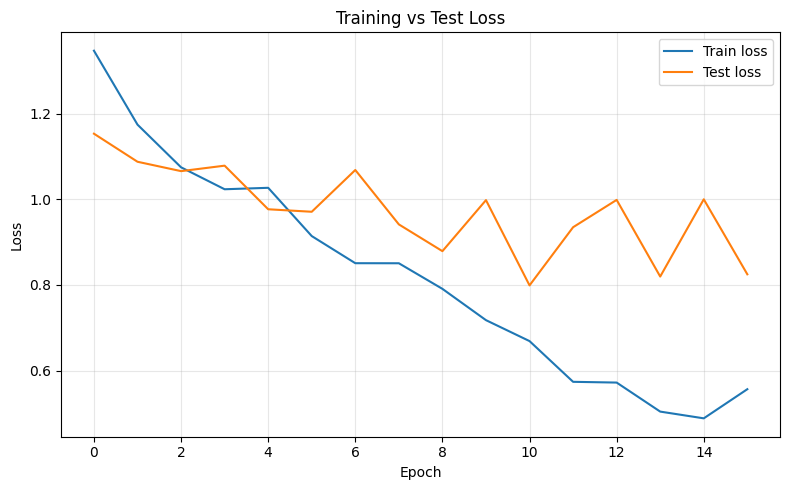

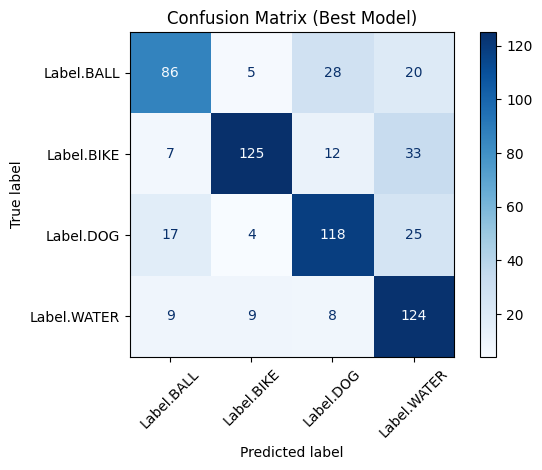

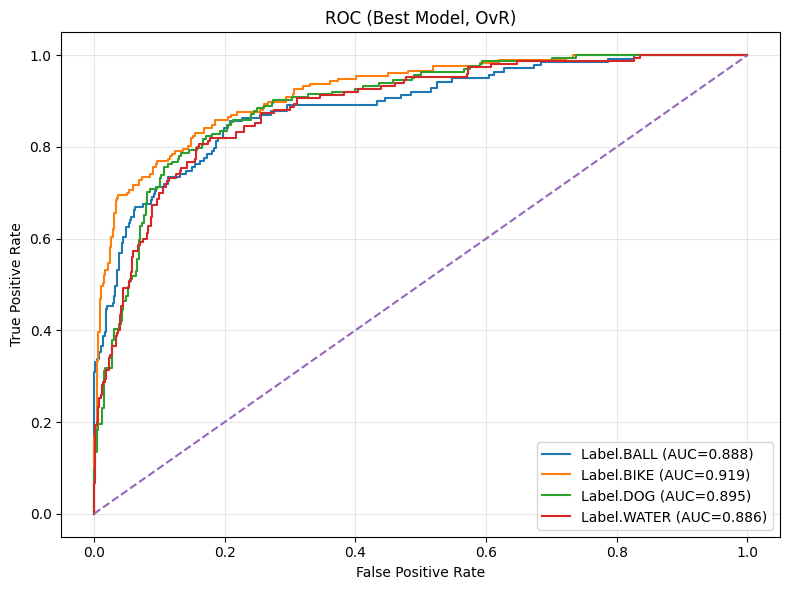

In [37]:
model = CNNBasic(4)  
trained_model, history = fit(
    model=model,
    train_loader=train_loader_custom,
    test_loader=test_loader_custom,
    num_classes=4,
    epochs=50,
    lr=1e-3,
    momentum=0.9,
    patience=5,
    models_dir=Path("../models"),
    best_name="best_model_2.pth",
    criterion=nn.CrossEntropyLoss(),
    class_names=class_names,
)

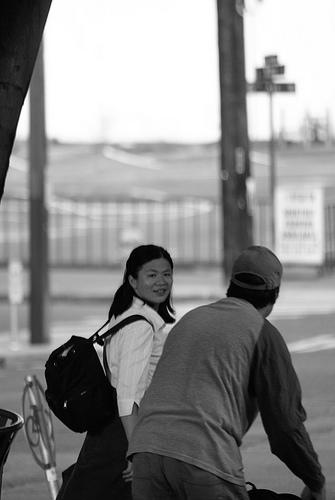


--- Mauvaise prédiction ---
dataset_idx : 0
image      : ../data/final_dataset/new_bike/bike_093/new_bike_093_color.jpg
vrai label : Label.BIKE (1)
prédit     : Label.WATER (3)
caption    : A young couple stands on a quiet city street, admiring a sleek bicycle leaning against a lamppost. The woman has just finished locking her backpack to the bike's rack and is now chatting with her friend about their upcoming cycling trip. A few feet away, a busy café is filled with the aroma of freshly brewed coffee, but the couple seems oblivious to the commotion, too engrossed in their conversation.


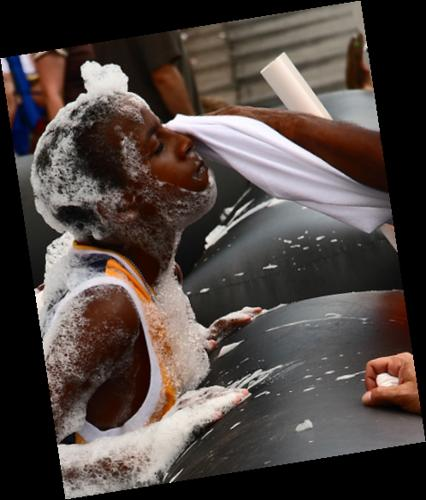


--- Mauvaise prédiction ---
dataset_idx : 9
image      : ../data/final_dataset/base_water/water_009/base_water_009_spatial.jpg
vrai label : Label.WATER (3)
prédit     : Label.BALL (0)
caption    : a boy cleans the bubbles off his face .


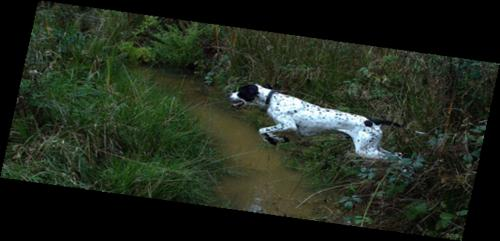


--- Mauvaise prédiction ---
dataset_idx : 12
image      : ../data/final_dataset/base_water/water_088/base_water_088_spatial.jpg
vrai label : Label.WATER (3)
prédit     : Label.BIKE (1)
caption    : A black and white spotted dog is jumping over the small stream of water .


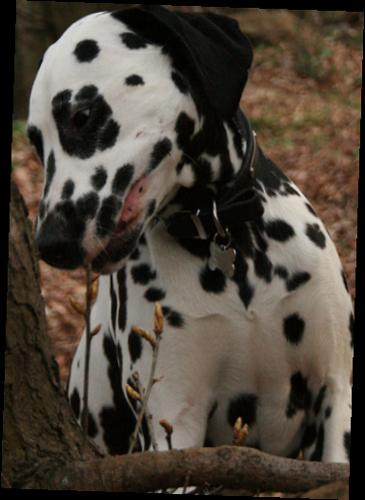


--- Mauvaise prédiction ---
dataset_idx : 13
image      : ../data/final_dataset/new_dog/dog_885/new_dog_885_spatial.jpg
vrai label : Label.DOG (2)
prédit     : Label.WATER (3)
caption    : A playful Dalmatian is frolicking near its favorite tree, chasing after a leaf that has caught its attention on a crisp autumn afternoon. The sun casts dappled shadows on the grass as the dog's energetic barks echo through the air. A nearby bird watches from a safe distance, curious about the commotion caused by the enthusiastic canine.


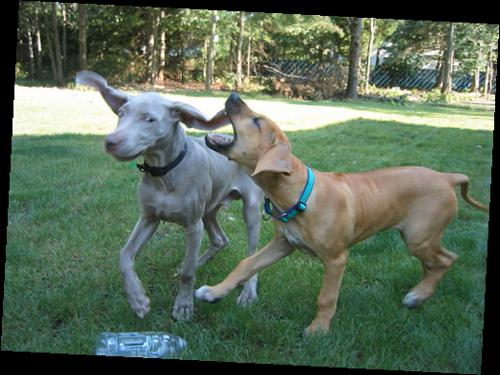


--- Mauvaise prédiction ---
dataset_idx : 16
image      : ../data/final_dataset/base_dog/dog_051/base_dog_051_spatial.jpg
vrai label : Label.DOG (2)
prédit     : Label.BALL (0)
caption    : A brown dog biting a gray dogs ear .


Epoch 1/1 [EVAL]: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Best model - TEST loss: 0.8291
Accuracy : 0.699999988079071



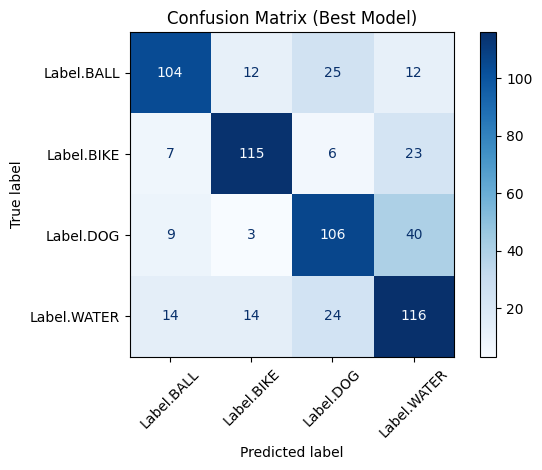

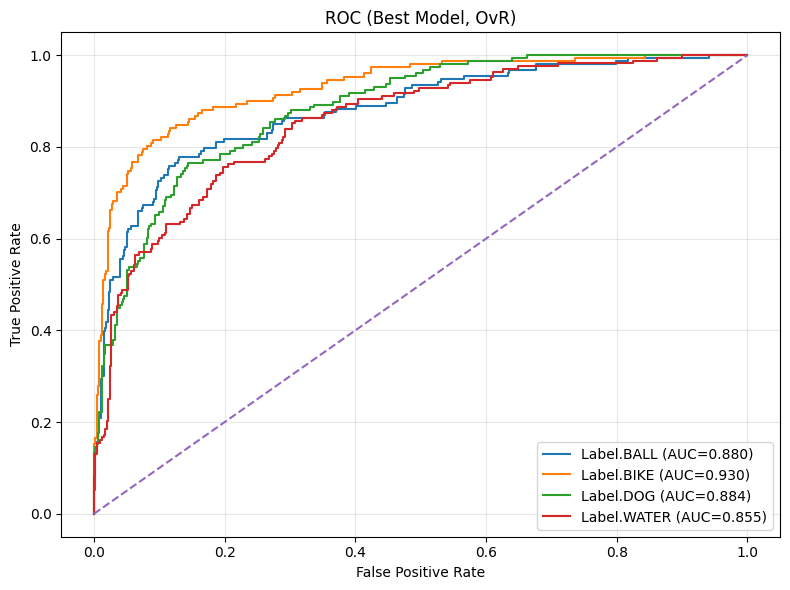

In [189]:
best_model_path = Path("../models/best_model_2.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = CNNBasic(num_classes=4)
model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(torch.load(best_model_path, map_location=device))

final_test_loss, y_true, y_pred, y_prob, acc = evaluate(
    model_loaded, val_loader_custom, criterion, device, class_names=class_names, epoch=0, epochs=1, num_classes=4,dataset=val_dataset_custom
)
print(f"Best model - TEST loss: {final_test_loss:.4f}")
print(f"Accuracy : {acc}\n")
plot_confusion_matrix(y_true, y_pred, class_names=class_names, title="Confusion Matrix (Best Model)")
plot_multiclass_roc(y_true, y_prob, num_classes=4, class_names=class_names, title="ROC (Best Model, OvR)")


--- Mauvaise prédiction ---
dataset_idx : 0
image      : ../data/final_dataset/new_bike/bike_093/new_bike_093_color.jpg
vrai label : Label.BIKE (1)
prédit     : Label.WATER (3)
caption    : A young couple stands on a quiet city street, admiring a sleek bicycle leaning against a lamppost. The woman has just finished locking her backpack to the bike's rack and is now chatting with her friend about their upcoming cycling trip. A few feet away, a busy café is filled with the aroma of freshly brewed coffee, but the couple seems oblivious to the commotion, too engrossed in their conversation.


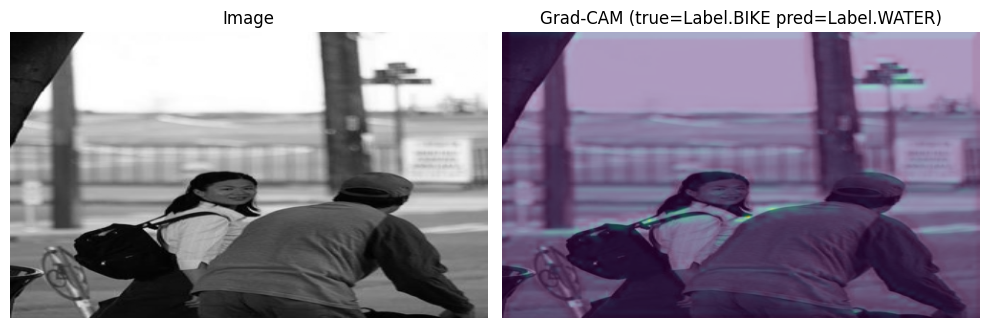


--- Mauvaise prédiction ---
dataset_idx : 9
image      : ../data/final_dataset/base_water/water_009/base_water_009_spatial.jpg
vrai label : Label.WATER (3)
prédit     : Label.BALL (0)
caption    : a boy cleans the bubbles off his face .


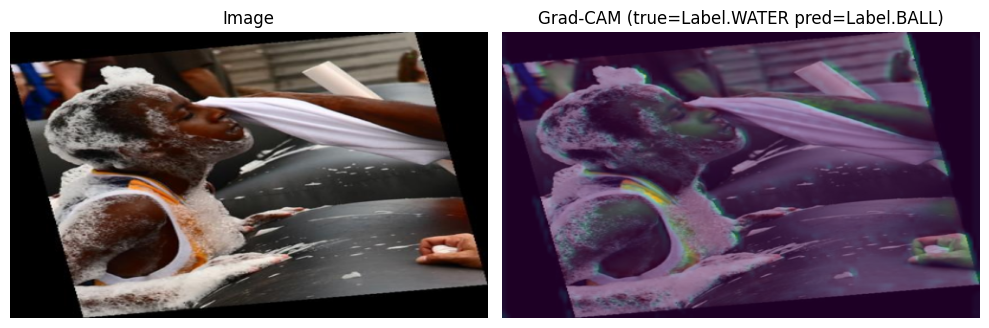


--- Mauvaise prédiction ---
dataset_idx : 12
image      : ../data/final_dataset/base_water/water_088/base_water_088_spatial.jpg
vrai label : Label.WATER (3)
prédit     : Label.BIKE (1)
caption    : A black and white spotted dog is jumping over the small stream of water .


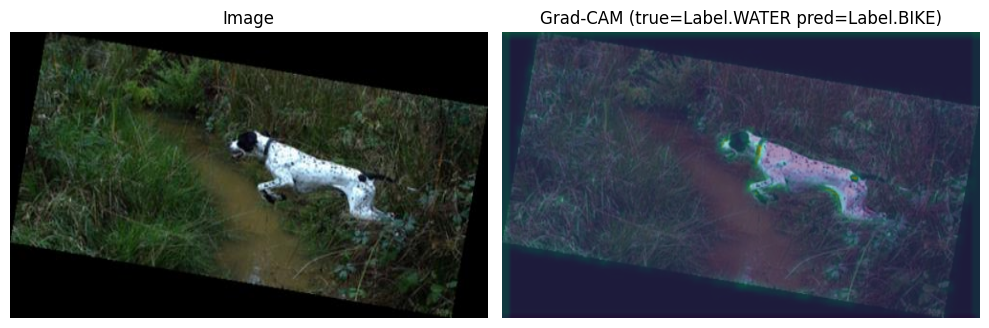


--- Mauvaise prédiction ---
dataset_idx : 13
image      : ../data/final_dataset/new_dog/dog_885/new_dog_885_spatial.jpg
vrai label : Label.DOG (2)
prédit     : Label.WATER (3)
caption    : A playful Dalmatian is frolicking near its favorite tree, chasing after a leaf that has caught its attention on a crisp autumn afternoon. The sun casts dappled shadows on the grass as the dog's energetic barks echo through the air. A nearby bird watches from a safe distance, curious about the commotion caused by the enthusiastic canine.


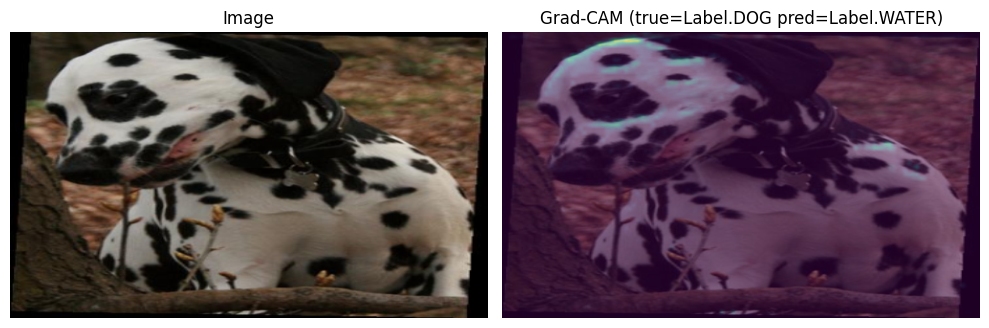


--- Mauvaise prédiction ---
dataset_idx : 16
image      : ../data/final_dataset/base_dog/dog_051/base_dog_051_spatial.jpg
vrai label : Label.DOG (2)
prédit     : Label.BALL (0)
caption    : A brown dog biting a gray dogs ear .


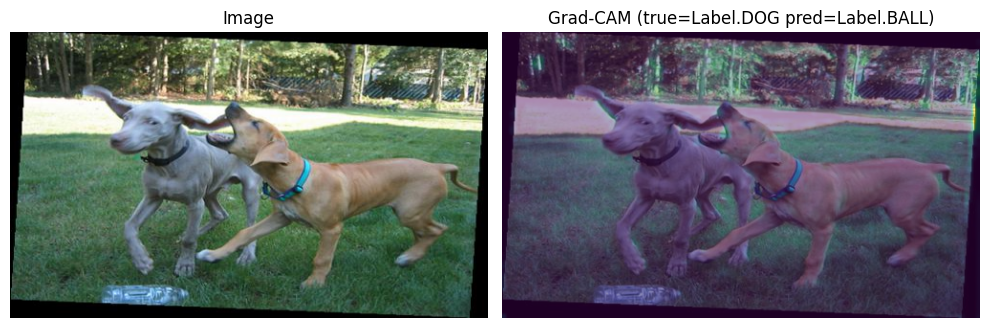

In [192]:
target_layer = model.features[8]
show_5_mistakes_with_gradcam(
    model=model_loaded,
    loader=val_loader_custom,
    device=device,
    class_names=class_names,
    target_layer=target_layer,
    dataset=val_dataset_custom,
    n=5
)

### RESNET TRAINING

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
num_classes = 4

model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # <--- ajoute compatibilité toutes tailles
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = model_resnet.to(device)


optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-5)



In [144]:
model_resnet_custom = ResNet18EarlyExit()
model_resnet_custom = model_resnet_custom.to(device)

In [145]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet_custom.parameters(), lr=1e-4, weight_decay=1e-5)

for epoch in range(5):
    model_resnet_custom.train()
    running_loss = 0.0
    for idx, inputs, labels in tqdm(train_loader, desc=f"TRAIN {epoch+1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model_resnet_custom(inputs)

        if isinstance(output, tuple):
            logits = output[0]
        else:
            logits = output

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Train loss = {running_loss/len(train_loader):.4f}")


TRAIN 1: 100%|██████████| 92/92 [00:17<00:00,  5.15it/s]


Epoch 1: Train loss = 0.6841


TRAIN 2: 100%|██████████| 92/92 [00:17<00:00,  5.16it/s]


Epoch 2: Train loss = 0.1690


TRAIN 3: 100%|██████████| 92/92 [00:17<00:00,  5.19it/s]


Epoch 3: Train loss = 0.0592


TRAIN 4: 100%|██████████| 92/92 [00:17<00:00,  5.17it/s]


Epoch 4: Train loss = 0.0365


TRAIN 5: 100%|██████████| 92/92 [00:17<00:00,  5.17it/s]

Epoch 5: Train loss = 0.0240


In [152]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
_, y_true, y_prob = evaluate(model_resnet_custom, val_loader, name="TEST")

# Classes (assure-toi que l'ordre correspond à l'entraînement)
class_names = ["Label.BALL", "Label.BIKE", "Label.WATER", "Label.DOG"]
n_classes = len(class_names)

# Binarisation One-vs-Rest
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_prob = np.array(y_prob)

# ROC par classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


TEST Loss: 0.3142
TEST Classification Report:
               precision    recall  f1-score   support

           0      0.841     0.935     0.885       153
           1      0.943     0.987     0.964       151
           2      0.919     0.791     0.850       158
           3      0.904     0.893     0.898       168

    accuracy                          0.900       630
   macro avg      0.902     0.901     0.900       630
weighted avg      0.902     0.900     0.899       630



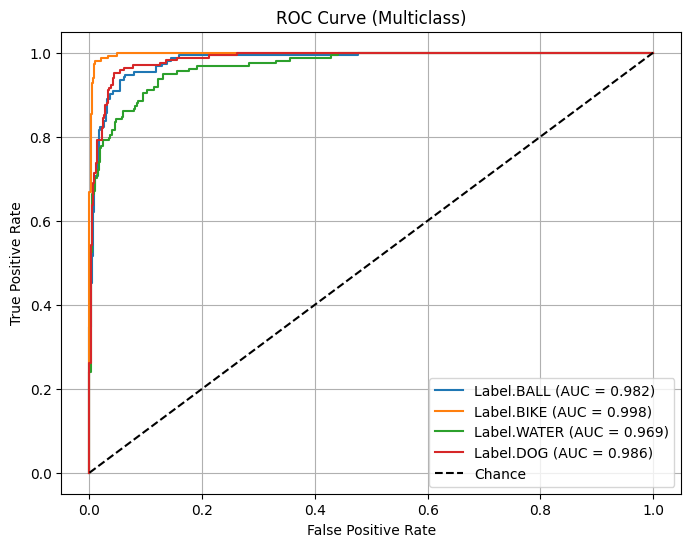

In [154]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



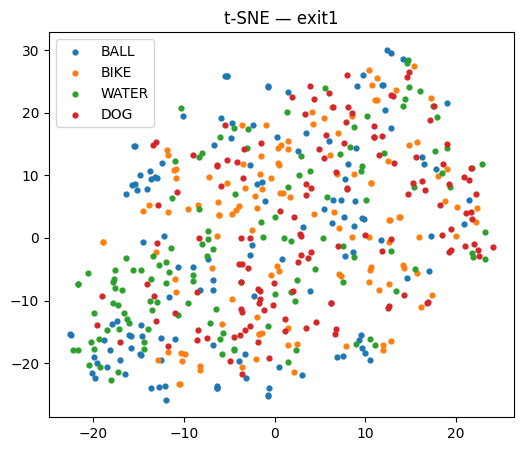

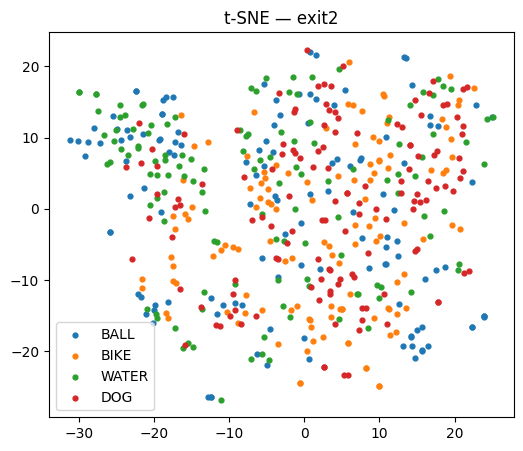

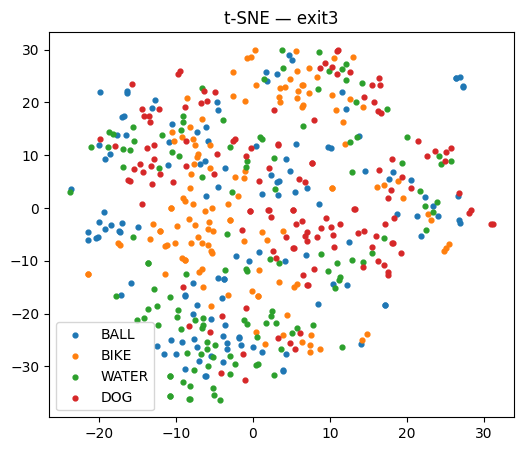

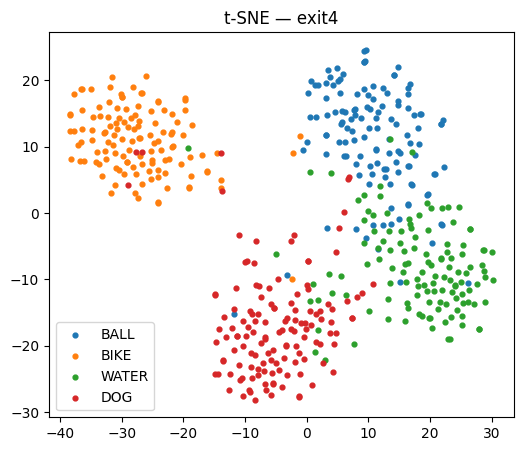

In [155]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(model, loader, class_names, max_samples=500):
    model.eval()
    feats = { "exit1": [], "exit2": [], "exit3": [], "exit4": [] }
    labels = []

    with torch.no_grad():
        for _, (idx, imgs, y) in enumerate(loader):
            imgs = imgs.to(device)

            features = model.extract_features(imgs)
            for k in feats.keys():
                feats[k].append(features[k].cpu().numpy())

            labels.append(y.numpy())
            if len(labels) * imgs.size(0) > max_samples:
                break

    for k in feats.keys():
        X = np.concatenate(feats[k], axis=0)
        Y = np.concatenate(labels, axis=0)

        X_2d = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(X)

        plt.figure(figsize=(6,5))
        for i, class_name in enumerate(class_names):
            pts = X_2d[Y == i]
            plt.scatter(pts[:,0], pts[:,1], s=12, label=class_name)

        plt.title(f"t-SNE — {k}")
        plt.legend()
        plt.show()

class_names = ["BALL", "BIKE", "WATER", "DOG"]
plot_tsne(model_resnet_custom, val_loader, class_names)


Collect misclassified:   0%|          | 0/20 [00:00<?, ?it/s]

Nb mauvaises prédictions (VAL): 63


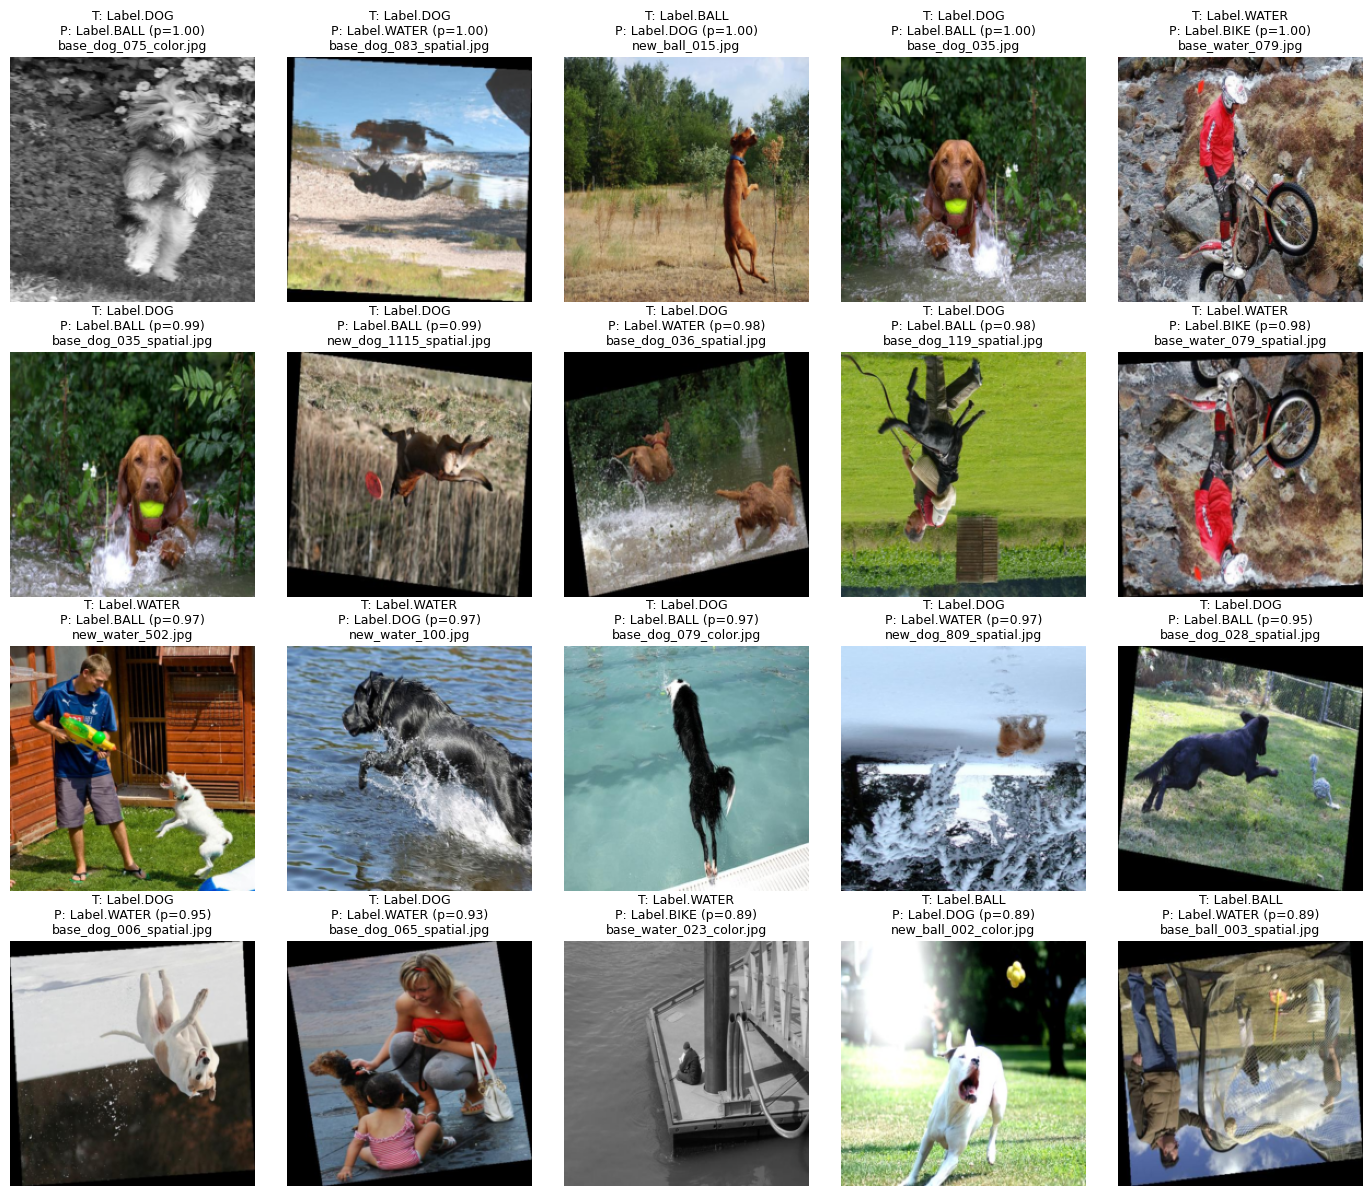

In [157]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denorm_img(x: torch.Tensor) -> torch.Tensor:
    x = x.detach().cpu() * IMAGENET_STD + IMAGENET_MEAN
    return x.clamp(0, 1)

def collect_misclassified(model, loader, dataset, device):
    model.eval()
    mis = []

    with torch.no_grad():
        for idxs, inputs, labels in tqdm(loader, desc="Collect misclassified", leave=False):
            # idxs reste CPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            if isinstance(output, (tuple, list)):
                logits = next((o for o in output if isinstance(o, torch.Tensor)), output[0])
            else:
                logits = output

            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(dim=1)

            # ✅ masque sur CPU pour indexer idxs (CPU)
            wrong_mask_cpu = preds.ne(labels).detach().cpu()

            if wrong_mask_cpu.any():
                wrong_idxs  = idxs[wrong_mask_cpu].cpu().tolist()
                wrong_imgs  = inputs.detach().cpu()[wrong_mask_cpu]   # inputs est GPU -> on cpu puis masque cpu
                wrong_true  = labels.detach().cpu()[wrong_mask_cpu].tolist()
                wrong_pred  = preds.detach().cpu()[wrong_mask_cpu].tolist()
                wrong_probs = probs.detach().cpu().numpy()[wrong_mask_cpu.numpy()]

                for j, ds_idx in enumerate(wrong_idxs):
                    path = dataset._get_img_path_from_idx(ds_idx)
                    mis.append({
                        "idx": int(ds_idx),
                        "path": path,
                        "img": wrong_imgs[j],              # tensor normalisé (3,H,W) CPU
                        "true": int(wrong_true[j]),
                        "pred": int(wrong_pred[j]),
                        "pred_prob": float(wrong_probs[j][wrong_pred[j]]),
                        "true_prob": float(wrong_probs[j][wrong_true[j]]),
                        "probs": wrong_probs[j],
                    })

    return mis

def show_misclassified(mis, idx_to_class, max_images=16, ncols=4, figsize=(14, 12),
                      sort_by="pred_prob", descending=True):
    if len(mis) == 0:
        print("✅ Aucune mauvaise prédiction.")
        return

    if sort_by is not None:
        mis = sorted(mis, key=lambda d: d.get(sort_by, 0.0), reverse=descending)

    n = min(len(mis), max_images)
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=figsize)
    for i in range(n):
        item = mis[i]
        img = denorm_img(item["img"])
        img_np = img.permute(1, 2, 0).numpy()

        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img_np)
        plt.title(
            f"T: {idx_to_class[item['true']]}\n"
            f"P: {idx_to_class[item['pred']]} (p={item['pred_prob']:.2f})\n"
            f"{item['path'].name}",
            fontsize=9
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Utilisation ----
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

mis_val = collect_misclassified(model_resnet_custom, val_loader, val_dataset, device)
print("Nb mauvaises prédictions (VAL):", len(mis_val))

show_misclassified(mis_val, idx_to_class, max_images=20, ncols=5, sort_by="pred_prob", descending=True)
